# Two-layer perceptron

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

## load the data

In [2]:
training_data = np.genfromtxt('data/training_set.csv', delimiter=',')
validation_data = np.genfromtxt('data/validation_set.csv', delimiter=',')

In [3]:
def preprocess_data(data):
    return data[:,0:2],np.expand_dims(data[:,-1],axis=1)

In [4]:
training_inputs,training_outputs = preprocess_data(training_data)
(training_inputs.shape,training_outputs.shape)

((10000, 2), (10000, 1))

In [5]:
validation_inputs,validation_outputs = preprocess_data(validation_data)

In [6]:
df = pd.read_csv('data/training_set.csv', delimiter=',',header=None)

In [7]:
df[0][df[2]==1].shape,df[0][df[2]==-1].shape

((1474,), (8526,))

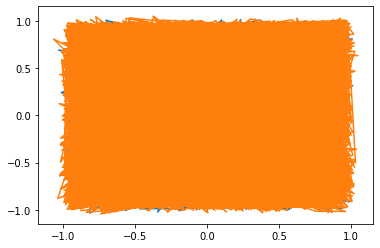

In [8]:
plt.plot(df[0][df[2]==1],df[1][df[2]==1])
plt.plot(df[0][df[2]==-1],df[1][df[2]==-1])

## Define the neural net

### 1. define a layer 

In [9]:
import numpy as np

class Layer_Perceptron:
    
    def __init__(self,number_of_input,number_of_neurons,activation_function,derivate_activation_function,weight=None,bias=None,random_weight=True,weight_range=0.2,bias_range=1):
        
        self.n = number_of_input
        self.m = number_of_neurons
        self._activation_function = activation_function
        self._derivate_activation_function = derivate_activation_function
        
        if (weight==None):
            if random_weight:
                self.w = weight_range*(2*np.random.rand(self.n,self.m)-1)
            else:
                self.w = np.zeros((self.n,self.m))
        
        else:
            if not(weight.shape== (self.n,)):
                raise ValueError(f"weight param should be of shape ({self.n},) but it is {weight.shape}")
            else:
                self.w = weight
        
        if (bias==None):
            if random_weight:
                self.b= bias_range*(2*np.random.rand(self.m,1)-1)
            else:
                self.b = 0
        
        else:
            self.b = bias
    
    
    def local_field(self,x):
        return ((self.w.T@x.T) + self.b).T
    
    def activate(self,x):        
        return self._activate_lf(self.local_field(x))
    
    def _activate_lf(self,lf):
        return self._activation_function(lf)
    
    def grad(self,x):
        return self._grad_lf(self.local_field(x))

    def _grad_lf(self,lf):
        return self._derivate_activation_function(lf)
    


In [10]:
activation_func = lambda x : np.tanh(x)
derivate_activation_func = lambda x :  (1-np.tanh(x)**2)

In [11]:
M1 = 3
M2 = 4

In [12]:
layer1 = Layer_Perceptron(training_inputs.shape[1],M1,activation_func,derivate_activation_func)
layer2 = Layer_Perceptron(layer1.w.shape[1],M2,activation_func,derivate_activation_func)
layer3 = Layer_Perceptron(layer2.w.shape[1],1,activation_func,derivate_activation_func)

In [13]:
layer1.activate(training_inputs[0:1,:]).shape

(1, 3)

### 2. Energies functions

In [14]:
class LossFunction:
    
    def __init__(self,loss,grad):
        self.loss = loss
        self.grad = grad
    
    def total_loss(self,inputs,outputs):
        return self.loss(inputs,outputs).mean()
    
    def total_grad(self,inputs,outputs):
        return self.grad(inputs,outputs).mean()


In [15]:
def energy_func(inputs,real_values):
    return ((inputs-real_values)**2)

def energy_derivate(inputs,real_values):
    return 2*(inputs-real_values)

energy = LossFunction(energy_func,energy_derivate)

### 3. NeuralNet

In [16]:
class NeuralNet:
    
    def __init__(self,layers):
        
        self.L = len(layers)
        self.layers = layers
    
    def activate(self,inputs,l=None): 
        if l == None:
            l= self.L-1
        if l ==-1:
            return inputs
        return self.layers[l]._activate_lf(self.local_field_forwad(inputs,l))
        
        
    def local_field_forwad(self,inputs,l):
        outputs = inputs
        for i in range(l):
            outputs = self.layers[i].activate(outputs)
        
 
        local_field = self.layers[l].local_field(outputs)
            
        return local_field  

In [17]:
nn = NeuralNet([layer1,layer2,layer3])

In [18]:
nn.local_field_forwad(training_inputs,2).shape

(10000, 1)

In [19]:
nn.activate(training_inputs,2).shape

(10000, 1)

## Gradient descent

In [52]:
M1 = 7
M2 = 8

wr=1
br=1

In [53]:
layer1 = Layer_Perceptron(training_inputs.shape[1],M1,activation_func,derivate_activation_func,weight_range=wr,bias_range=br)
layer2 = Layer_Perceptron(layer1.w.shape[1],M2,activation_func,derivate_activation_func,weight_range=wr,bias_range=br)
layer3 = Layer_Perceptron(layer2.w.shape[1],1,activation_func,derivate_activation_func,weight_range=wr,bias_range=br)

In [54]:
nn = NeuralNet([layer1,layer2,layer3])

In [55]:
loss = energy
inputs = training_inputs
outputs = training_outputs

In [56]:
lr = 0.2
max_iter = int(1e3)

In [57]:
losses = np.zeros(max_iter)
losses_val = np.zeros(max_iter)

100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


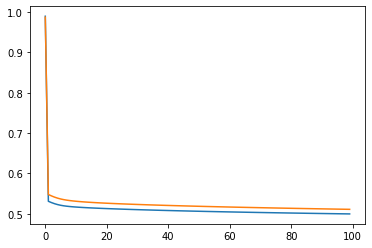

In [58]:
grads_w = [np.zeros(layer.w.shape) for layer in nn.layers]
grads_b = [np.zeros(layer.b.shape) for layer in nn.layers]



for epoch in tqdm(range(max_iter)):
    
    losses[epoch] = loss.total_loss(nn.activate(inputs),outputs)
    losses_val[epoch] = loss.total_loss(nn.activate(validation_inputs),validation_outputs)
    
    back_prop = loss.grad(nn.activate(inputs),outputs)
    
    for i in reversed(range(nn.L)):
        l = nn.layers[i]
        nb_inputs = inputs.shape[0]

        grad_layer = l._grad_lf(nn.local_field_forwad(inputs,i))
        activation= nn.activate(inputs,i-1)
        
        
        grads_w[i] = activation.T@(back_prop*grad_layer)/nb_inputs
        grads_b[i] = (np.ones((activation.shape[0],1)).T@(back_prop*grad_layer)).T/nb_inputs

        back_prop = (grad_layer*back_prop)@l.w.T


    for i in range(nn.L):

        nn.layers[i].w =nn.layers[i].w - lr*grads_w[i]
        nn.layers[i].b =nn.layers[i].b - lr*grads_b[i]



plt.plot(losses)
plt.plot(losses_val)

# errors pourcentage

In [59]:
1- (np.sign(nn.activate(validation_inputs))==validation_outputs).mean()

0.15159999999999996

In [60]:
np.abs((np.sign(nn.activate(validation_inputs)) - validation_outputs)).mean()/2

0.1516